<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   User ID           400 non-null    int64 
 1   Gender            400 non-null    object
 2   Age               400 non-null    int64 
 3   EstimatedSalary   400 non-null    int64 
 4   Purchased         400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


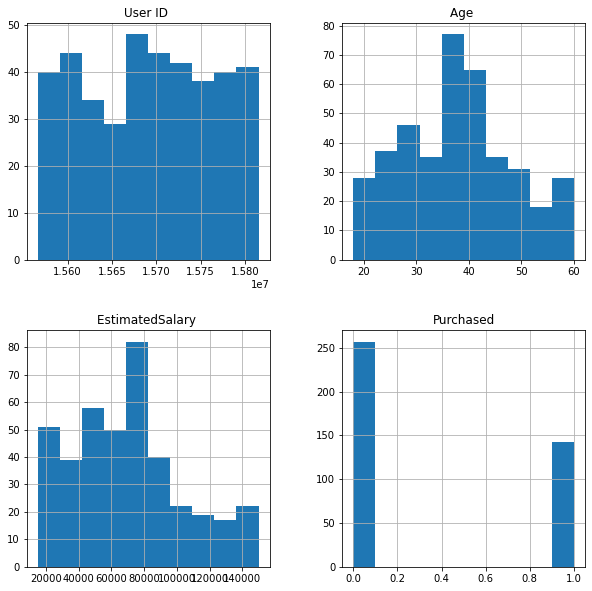

LR   : 0.685714 (0.106904)
NB   : 0.885714 (0.076265)
DT   : 0.835714 (0.066240)
RF   : 0.889286 (0.051632)
SVM   : 0.767857 (0.068232)
KNN   : 0.807143 (0.055787)


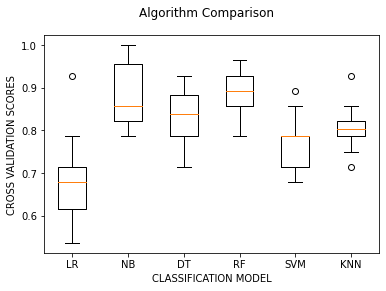

Accuracy: 0.8625
Classification Report 
               precision    recall  f1-score   support

           0       0.93      0.84      0.88        50
           1       0.77      0.90      0.83        30

    accuracy                           0.86        80
   macro avg       0.85      0.87      0.86        80
weighted avg       0.87      0.86      0.86        80

[[42  8]
 [ 3 27]]


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import zscore
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import train_test_split as TTS
import warnings
warnings.filterwarnings("ignore")

#data extraction
data = pd.read_csv(r'/Users/mohamedarshath/Library/Containers/com.microsoft.Excel/Data/Downloads/SD03Q012/Social_Network_Ads.csv')
X = data.iloc[:, [2, 3]].values
y = data.iloc[:, 4].values

#EDA
data.describe()

data.info()

data.isnull().sum()
#plot
data.hist(figsize=(10,10))
plt.show()

#best plot
lr = LR(C = 0.2, max_iter = 1000)
nb = NB()
dt = tree.DecisionTreeClassifier(criterion='entropy')
rf = RFC(max_depth=5, random_state=0)
svm = SVC(probability=True)
knn = KNN(n_neighbors = 5, metric = 'minkowski', p = 2)

models = []
models.append(('LR', lr))
models.append(('NB', nb))
models.append(('DT', dt))
models.append(('RF', rf))
models.append(('SVM', svm))
models.append(('KNN', knn))
results = []
names = []
scoring = 'accuracy'

X_train,X_test,y_train,y_test = TTS(X, y, test_size = 0.3, random_state = 0)


for name, model in models:
	kfold = model_selection.KFold(n_splits = 10)
	cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s   : %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.xlabel("CLASSIFICATION MODEL")
plt.ylabel("CROSS VALIDATION SCORES")
ax.set_xticklabels(names)
plt.show()

#random forest classifier
def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])


class Node:

    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:

    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (depth >= self.max_depth
                or n_labels == 1
                or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        
        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common
    
import numpy as np
from collections import Counter

def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return X[idxs], y[idxs]

def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common


class RandomForest:
    
    def __init__(self, n_trees=10, min_samples_split=2,
                 max_depth=100, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(min_samples_split=self.min_samples_split,
                max_depth=self.max_depth, n_feats=self.n_feats)
            X_samp, y_samp = bootstrap_sample(X, y)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)
    
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

data = pd.read_csv(r'/Users/mohamedarshath/Library/Containers/com.microsoft.Excel/Data/Downloads/SD03Q012/Social_Network_Ads.csv')
X = data.iloc[:, [2, 3]].values
y = data.iloc[:, 4].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

clf = RandomForest(n_trees=3, max_depth=10)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy(y_test, y_pred)

print ("Accuracy:", acc)
from sklearn.metrics import confusion_matrix,classification_report
print('Classification Report \n', classification_report(y_test, y_pred))
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)


#model visualisation
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Random Forest Classification (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()